# Preclass Assignment: Day 16 (Oct 29, 2025)<br>Fitting
Learning goals
1. Use the scatter operator `*` when calling a function
1. Use `scipy.optimize.curve_fit` to fit a model to an x-y data set and extract the fitting parameters
1. Use extracted fitting parameters to plot the best fit model
1. Extract uncertainties from fitting parameters
1. Include absolute y-data uncertainties in the fit
1. Make good initial guesses of the fitting parameters to improve the chance that the real best fit will be found instead of a local minimum

## *No self-assessment questions for this reading*

Although you have likely interacted with many of these concepts in Physics 219 and elsewhere, we're presenting some of the details in different ways that you may have encountered so would like everybody to work their way through this notebook. There are some Your Turn questions embedded throughout to help you test your understanding.

## *Fitting with `scipy.optimize.curve_fit`*

The main fitting routine that we will use in this course is the `scipy` fitting routine `curve_fit()`. You can read more about it at:
    
* http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

This fitting routine uses non-linear least squares fitting. For those of you that took Physics 119, this is the same as minimizing chi-squared by minimizing the sum of the residuals squared. 

## _1. The scatter operator `*`_

Before discussing `scipy.optimize.curve_fit`, we need to first discuss using the `*` operator with arguments when calling a function. When used this way it is called the scatter or splat operator. It is used to unpack a container (such as a list, tuple or array) into its individual elements---as *positional arguments*---when passing this argument to a function.

Let's first look at a typical function call with three arguments. The code below shows a function that sums three numbers. If those three numbers were in a list, we could index each individual number when we call the function, as shown below. 

In [1]:
def sum_of_three_numbers(a, b, c):
    return a + b + c

# The list of numbers
numbers = [1, 2, 3]

# Call the function using indexing to pass each individual number
mysum = sum_of_three_numbers(numbers[0], numbers[1], numbers[2])

# Print the result
print(mysum)

6


Alternatively, we can put the scatter operator in front of our list (i.e., `*numbers`) when we call our function. What this does is unpacks the list `numbers` into the individual elements `numbers[0]`, `numbers[1]` and `numbers[2]` and then passes those to the function. We will see that this is very handy when we use of best-fit parameters to plot our model functions when using `scipy.optimize.curve_fit`.

In [2]:
# Call the function using our 'numbers' list directly thanks to the scatter operator
mysum = sum_of_three_numbers(*numbers)

print(mysum)

6


### Your Turn #1

Consider the following code. Which line would cause an error, and why?
```python
def subtract(a, b, c):
    return a - b - c

args1 = [5, 3]
args2 = [5, 3, 1]

result1 = subtract(*args1)
result2 = subtract(*args2)
```
A) `result1 = subtract(*args1)` will cause an error because args1 has two elements.<br>
B) `result1 = subtract(*args1)` will cause an error because args1 is a list.<br>
C) `result2 = subtract(*args2)` will cause an error because args2 has three elements.<br>
D) `result2 = subtract(*args1)` will cause an error because args2 is a list.<br>
E) More than one of the above are true.<br>
F) None of the lines will cause an error.

In [ ]:
# Code testing area to help answer this question



In [3]:
# Enter your answer inside the string quotes and run this cell to check your anwer

answer = "A"

import hashlib
assert answer in ['A', 'B', 'C', 'D', 'E', 'F'], "Your answer did not match any of the choices"
assert hashlib.sha256(answer.encode()).hexdigest() == \
    '559aead08264d5795d3909718cdd05abd49572e84fe55590eef31a88a08fdffd', "Your answer is incorrect"
print("Your answer", answer, "is correct") # Passed all assert statements above

Your answer A is correct


## *2. An initial linear fit, <u>without</u> uncertainties*

Here we provide a data set that we are going to try to mode using a straight line, $y=mx+b$. 

First, let's plot these data so we have a sense of what they look like.

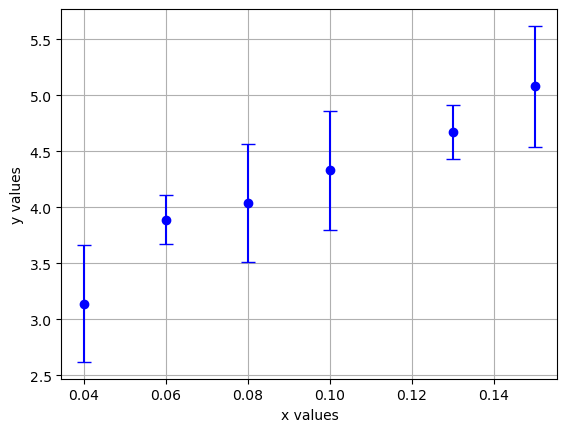

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x_data = np.array([.04, .06, .08, .1 , .13, .15])
y_data = np.array([3.14, 3.89, 4.04, 4.33, 4.67, 5.08])
yerror = np.array([0.52, 0.22, 0.53, 0.53, 0.24, 0.54])

plt.errorbar(x_data, y_data, yerr=yerror, fmt = "bo", capsize=5)
plt.xlabel('x values')
plt.ylabel('y values')
plt.grid(True)
plt.show()

These look plausbily linear. Based on some quick mental math, we can get initial estimates of the slope and y-intercept for this data set. 

Ignoring uncertainties for now, we can notice that the data show a rise of approximately 2 units ($\approx 5-3$) over a run of approximately 0.1 units ($\approx 0.14-0.04$). Thus the slope is approximately $2/0.1 \approx 20$. A reasonable estimate for the y-intercept would be $\approx 2.0 \mbox{ units}$.

Let's run the fit and double-check that the results make some sense. 

**Important!** Although our data do have y-uncertainties, we won't use them yet with `curve_fit`.

In [5]:
# This allows us to use scipy's 'optimize.curve_fit'
from scipy import optimize

# Like with solve_ivp, we need to define a function that curve_fit will interact with
# - The first parameter will always be the x variable
# - The subsequent parameters will be our parameters for our fitting function
# - Finally, we return what this function would calculate our y value to be
#   so that curve_fit can compare it to y_data
def line(x, m, b):
    return m*x + b

# curve_fit returns a tuple consisting of
# - An array of our best-fit parameters, which we call fitparams
# - A covariance matrix (fitcov) from which we can extract the uncertainties in our
#   best-fit parameters.
fitparams, fitcov = optimize.curve_fit(line, x_data, y_data)

# Print the results
print(f"m = {fitparams[0]:.1f};  b = {fitparams[1]:.2f}")

# The diagnonal of the covariance matrix gives the variance (standard deviation squared)
# of our fitting parameters and the off-diagnonals communicate the correlations between
# our fitting parameters. To get the uncertainty in each fitting parameter, we need to take
# the square root of the variance.
#
# Important! Since we are not yet using the data y-uncertainties in our fit, these
# uncertainties in δm and δb are mostly meaningless at this point.
#
dfitparams = np.sqrt(np.diag(fitcov))
print(f"δm = {dfitparams[0]:.2};  δb = {dfitparams[1]:.2}")

m = 15.7;  b = 2.73
δm = 1.8;  δb = 0.18


We find that our initial estimates of these parameters (`m = 20`, `b = 2`) were somewhat reasonable, but were more that one standard deviation away from the actual results. 

**Let's graph the results.**

In the code below we will use our previously defined function `line()`, but here we will use the scatter operator `*` (e.g., `yf = line(xf, *fitparams)`) to pass all of our fit parameters using a very concise line of code. 

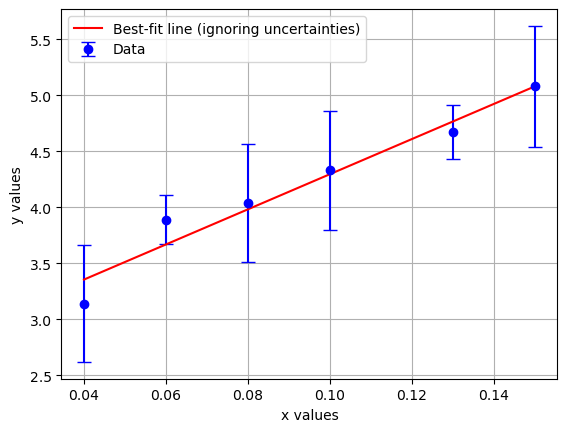

In [6]:
## Let's plot the best fit line

# To produce a smooth curve, we need to produce a large number x values over the data
# range, and can then determine the corresponding y values using our line function
xf = np.linspace(x_data.min(), x_data.max(), num = 200)

# We re-use our `line` function from before. We use "*fitparams", which is automatically
# unpacked it into fitparams[0] and fitparams[1] when passed to the line() function
yf = line(xf, *fitparams)

# Plot the data again
plt.errorbar(x_data, y_data, yerr=yerror, fmt = "bo", capsize=5, label="Data")
plt.xlabel('x values')
plt.ylabel('y values')

# Add the best fit line
plt.plot(xf, yf, "r-", label="Best-fit line (ignoring uncertainties)")

# Add a grid and legend and show then show the entire plotting canvas
plt.grid(True)
plt.legend()
plt.show()

Our next step is to incorporate the y-uncertainties from our into our fit.

## *3. Including uncertainties in our fit*

We will use two optional arguments to communicate to `curve_fit` that we want it to use the data y-uncertainties in our fit. This will use the most common physics approach of weighting each data point by 1/yerror<sup>2</sup>. 
1. Our first optional argument is `sigma = yerror`, which tells `curve_fit` that our "one sigma" errors are stored as `yerror`. 
2. Our second optional argument is `absolute_sigma = True`, which tells `curve_fit` to treat these as absolute errors, which is how we are plotting them. If set to `False` or not specified, `curve_fit` will treat these as relative errors.

In [7]:
# We can re-use our previous `line` function so just need to call `curve_fit` with
# our new optional arguments

fitparams2, fitcov2 = optimize.curve_fit(line, x_data, y_data, sigma = yerror, absolute_sigma = True)

dfitparams2 = np.sqrt(np.diag(fitcov2))

print(f"m = {fitparams2[0]:.1f};  b = {fitparams2[1]:.2f}")
print(f"δm = {dfitparams2[0]:.2};  δb = {dfitparams2[1]:.2}")

m = 13.2;  b = 3.00
δm = 3.8;  δb = 0.38


Let's plot our results. 

Note that since we previously created the array `xf` to help us with plotting our best-fit lines, we can use `xf` and our new fitting parameters `fitparams2` to determine the y-values for this new fit, `yf2`.

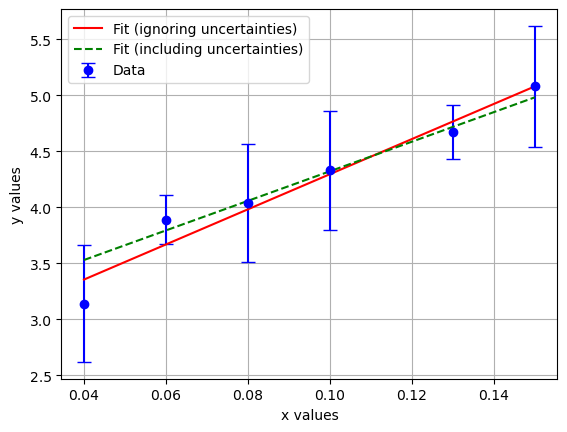

In [8]:
# Calculate the y-values of our updated fit
yf2 = line(xf, *fitparams2)

# Plot the data
plt.errorbar(x_data, y_data, yerr=yerror, fmt = "bo", capsize=5, label="Data")
plt.xlabel('x values')
plt.ylabel('y values')

# Plot the old best fit line
plt.plot(xf, yf, "r-", label="Fit (ignoring uncertainties)")

# ...and the new best fit line
plt.plot(xf, yf2, "g--", label="Fit (including uncertainties)")

plt.grid(True)
plt.legend()
plt.show()

We can see that the including `yerror` in the fit as absolute errors results in a fit that gives much more weight to the two data points with small uncertainties, as shown by the dashed green line having a lower slope and passing much more closely to the middle of those two data points with small uncertainties.

### Your Turn #2

In the following code, why do we include `absolute_sigma = True`?

```python
fitparams2, fitcov2 = optimize.curve_fit(line, x_data, y_data, sigma = yerror, absolute_sigma = True)
```

A) To ensure that the `sigma = yerror` values are interpreted as relative errors rather than absolute errors.<br>
B) To ensure that the `sigma = yerror` values are interpreted as absolute errors rather than relative errors.<br>
C) To normalize the `y_data` values before fitting the curve.<br>
D) To constrain the parameters so that they stay within certain bounds.

In [ ]:
# Code testing area to help answer this question



In [9]:
# Enter your answer inside the string quotes and run this cell to check your anwer

answer = "B"

import hashlib
assert answer in ['A', 'B', 'C', 'D'], "Your answer did not match any of the choices"
assert hashlib.sha256(answer.encode()).hexdigest() == \
    'df7e70e5021544f4834bbee64a9e3789febc4be81470df629cad6ddb03320a5c', "Your answer is incorrect"
print("Your answer", answer, "is correct") # Passed all assert statements above

Your answer B is correct


## *4. Extracting fitting parameter uncertainties*

Let's take a moment to understand a bit better how we have been extracting the fitting parameter uncertainties `δm` and `δb` in our previous calls to `curve_fit`.

First, let's repeat our most recent fit. Be reminded that `curve_fit` returns two arrays, which we assign to `fitparams2` and `fitcov2` in this example.

1. `fitparams2` (called `popt` in the `curve_fit` documentation) returns a 1D array of the optimal values of the parameters resulting from minimization of the sum of the squared residuals. In our example, `fitparams2[0]` gives us `m` and `fitparams2[1]` gives us `b`.<br><br>
1. `fitcov2` (called `pcov` in the `curve_fit` documentation) returns a 2D array where the diagnonal of the covariance matrix gives the variance (standard deviation squared) of our fitting parameters and the off-diagnonals communicate the correlations between our fitting parameters. 
   * This means we need to first extract the diagonal of this 2D array and then take the square root. This will give a 1D array of the uncertainties in our fitting parameters. We do this in smaller steps below.

In [10]:
fitparams2, fitcov2 = optimize.curve_fit(line, x_data, y_data, sigma = yerror, absolute_sigma = True)

print("The covariance matrix fitcov2:\n", fitcov2)

print("\nThe diagonal of fitcov2:\n", np.diag(fitcov2))

# This gives the uncertainties in our fitting parameters given by fitparams2
print("\nThe squareroot of the diagonal of fitcov2:\n", np.sqrt(np.diag(fitcov2)))

The covariance matrix fitcov2:
 [[14.59817335 -1.34049608]
 [-1.34049608  0.14222428]]

The diagonal of fitcov2:
 [14.59817335  0.14222428]

The squareroot of the diagonal of fitcov2:
 [3.8207556  0.37712634]


## *5. Initial guesses for fitting parameters*

The process of least-squares fitting involves looking for a minumum in the sum of the residuals squared, where a residual is the distance between a data point and the value predicted by the model for that data point. Models will have an absolute minimum value chi-squared, corresponding to the best possible fit of that model to those data, **but many models will also have many local minima**. This means that `curve_fit` may find a solution that minimizes the sum of the residuals squared as compared to nearby variations of the solution parameters, but which is not absolute minimum. Let's take a look.

First, let's load some initial data and plot them.

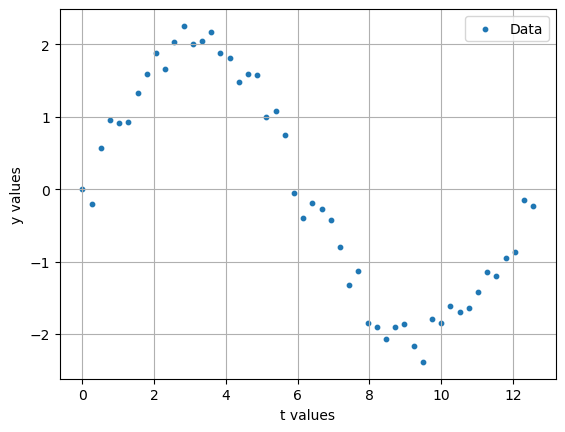

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

t_data = np.array([ 0.        ,  0.25645654,  0.51291309,  0.76936963,  1.02582617,
        1.28228272,  1.53873926,  1.7951958 ,  2.05165235,  2.30810889,
        2.56456543,  2.82102197,  3.07747852,  3.33393506,  3.5903916 ,
        3.84684815,  4.10330469,  4.35976123,  4.61621778,  4.87267432,
        5.12913086,  5.38558741,  5.64204395,  5.89850049,  6.15495704,
        6.41141358,  6.66787012,  6.92432667,  7.18078321,  7.43723975,
        7.69369629,  7.95015284,  8.20660938,  8.46306592,  8.71952247,
        8.97597901,  9.23243555,  9.4888921 ,  9.74534864, 10.00180518,
       10.25826173, 10.51471827, 10.77117481, 11.02763136, 11.2840879 ,
       11.54054444, 11.79700098, 12.05345753, 12.30991407, 12.56637061])
y_data = np.array([-1.71815239e-03, -2.08015913e-01,  5.64748219e-01,  9.62492904e-01,
        9.20418866e-01,  9.35737259e-01,  1.32776675e+00,  1.58956031e+00,
        1.88558979e+00,  1.66143882e+00,  2.03767118e+00,  2.25638778e+00,
        2.00445035e+00,  2.04773244e+00,  2.17685040e+00,  1.88546903e+00,
        1.81505858e+00,  1.48373884e+00,  1.59274906e+00,  1.57320479e+00,
        9.91393316e-01,  1.08707412e+00,  7.51733967e-01, -4.56799784e-02,
       -3.91397237e-01, -1.96417994e-01, -2.74839190e-01, -4.23692135e-01,
       -7.91822825e-01, -1.31857939e+00, -1.12749963e+00, -1.84915218e+00,
       -1.90104185e+00, -2.06498665e+00, -1.90021998e+00, -1.85630497e+00,
       -2.16964289e+00, -2.38494504e+00, -1.79373814e+00, -1.84252623e+00,
       -1.61829111e+00, -1.70084067e+00, -1.63726353e+00, -1.41318373e+00,
       -1.14480241e+00, -1.20080281e+00, -9.50884586e-01, -8.69321294e-01,
       -1.45618763e-01, -2.32657944e-01])

plt.scatter(t_data, y_data, s=10, label='Data')
plt.xlabel('t values')
plt.ylabel('y values')
plt.grid(True)
plt.legend()
plt.show()

We're expecting these data to be described by the model 

$$a \sin{\omega t}.$$

Like we did previously, we can generate some initial estimates of the fitting parameters by knowing the model function and inspecting the behaviour of the data. 
* Since this is a sin wave, we can observe a reasonably obvious amplitude of approximately 2, allowing us to set our initial guess of the related term to $a = 2$. 
* We can also see that it takes approximately 12 time units to go through one full period. Knowing that the relationship between period and angular frequency is $\omega = 2\pi/T$, this gives us an estimate of $\omega \approx 2\pi/12 \approx 0.5$. Let's keep these values in mind as we proceed with this fit.

Although we have developed some good initial guesses for the fitting parameters, **let's first perform a fit without providing any initial guesses for our fitting parameters.**

a = 0.0951;  omega = 1.1


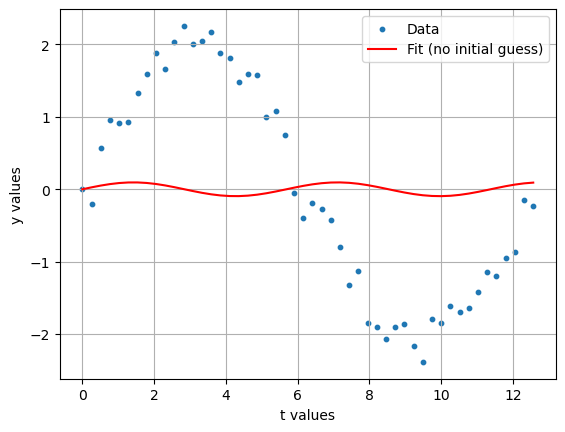

In [12]:
# Define the sum of sine waves function
def sin_model(x, a, omega):
    return a * np.sin(omega * x)

# Fit with no initial guess
popt_no_guess, pcov_no_guess = curve_fit(sin_model, t_data, y_data)

# Print the "no guess" best fit parameters
print(f"a = {popt_no_guess[0]:.3};  omega = {popt_no_guess[1]:.3}")

# Generate our graphs
plt.scatter(t_data, y_data, s=10, label='Data')
plt.plot(t_data, sin_model(t_data, *popt_no_guess), 'r-', label='Fit (no initial guess)')
plt.xlabel('t values')
plt.ylabel('y values')
plt.grid(True)
plt.legend()
plt.show()

**WHAT THE WHAT?!?!?! Why did this fail so spectacularly?**

`curve_fit` requires initial guesses for each parameter and if it does not receive any initial guesses, it provides default values of `1` for each parameter.

In the code we did not provide any initial guesses so it used its default values of `1`. Why is this a problem?

Well, `curve_fit` starts the fitting process with a model using values that correspond to the predictions made according to the initial guesses for the parameters. Since we didn't specify our initial guesses, it used default values of `a = 1` and `omega = 1`. After starting with these initial parameter guesses, it varies these parameters slowly while monitoring the sum of residuals squared to determine when it has found a minimum chi-squared. 

The code below builds a graph of chi-squared vs various omega values, ranging from `omega = 0.1 - 2.0`, while holding the amplitude fixed at `a = 1`. On the graph we see a nice deep minimum in chi-squared correspoding to `omega = 0.48`, but we also notice that there is another "local" minumum around `omega = 1.1`. 

Since we started with the default initial guess of `omega = 1`, the `curve_fit` function found that increasing `omega` reduced chi-squared and then it fell into a local minimum at `omega = 1.1`, where neither increasing nor decreasing `omega` improved chi-squared further. 

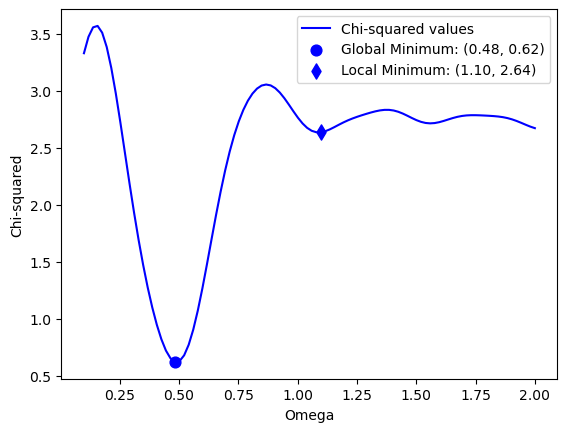

In [13]:
# Define the chi-squared calculation function
def get_chi2(p0):
    residuals = y_data - sin_model(t_data, *p0)
    return sum(residuals**2) / (len(y_data) - 2)

# Set up omega values and empty chi2_vals
omega_vals = np.linspace(0.1, 2.0, 100)
chi2_vals = np.empty_like(omega_vals)

# Fixed parameter 'a'
a = 1

# Calculate chi-squared values for each omega
for i, omega in enumerate(omega_vals):
    p = (a, omega)
    chi2_vals[i] = get_chi2(p)

# Find the global minimum chi-squared and its corresponding omega
global_min_chi2 = np.min(chi2_vals)
global_min_omega = omega_vals[np.argmin(chi2_vals)]

# Find the local minimum chi-squared in the range omega = 1 to omega = 1.25
mask = (omega_vals >= 1) & (omega_vals <= 1.25)
restricted_chi2_vals = chi2_vals[mask]
restricted_omega_vals = omega_vals[mask]
local_min_chi2 = np.min(restricted_chi2_vals)
local_min_omega = restricted_omega_vals[np.argmin(restricted_chi2_vals)]

# Plot chi-squared values against omega
plt.plot(omega_vals, chi2_vals, label='Chi-squared values', color = 'b')
plt.scatter(global_min_omega, global_min_chi2, marker='o', 
            label=f'Global Minimum: ({global_min_omega:.2f}, {global_min_chi2:.2f})', color = 'b', s=60)
plt.scatter(local_min_omega, local_min_chi2, marker='d', 
            label=f'Local Minimum: ({local_min_omega:.2f}, {local_min_chi2:.2f})', color = 'b', s=60)
plt.xlabel('Omega')
plt.ylabel('Chi-squared')
plt.legend()
plt.show()

**Let's use some slightly better initial guesses than `p0=[1, 1]`**

For our initial guesses, let's use our estimates from the start of this section ($a\approx 2$ and $\omega \approx 0.5$) as an optional argument to `curve_fit` using `p0=[2, 0.5]`.

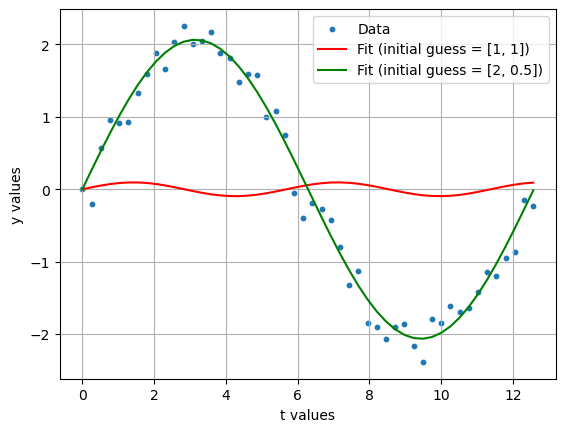

In [14]:
# Fit with an initial guess
popt_guess, pcov_guess = curve_fit(sin_model, t_data, y_data, p0=[2, 0.5])

# Plot
plt.scatter(t_data, y_data, s=10, label='Data')
plt.plot(t_data, sin_model(t_data, *popt_no_guess), 'r-', label='Fit (initial guess = [1, 1])')
plt.plot(t_data, sin_model(t_data, *popt_guess), 'g-', label='Fit (initial guess = [2, 0.5])')
plt.xlabel('t values')
plt.ylabel('y values')
plt.grid(True)
plt.legend()
plt.show()

**Hopefully you can see the importance of initial guesses when fitting to nonlinear functions.**

### Your Turn #3

For the following exponential decay data, try to come up with your best initial guesses for the parameters `a`, `b` and `c`. 

1. The first code box plots the data. 
2. The second code box allows you to enter your best initial guesses for a, b and c. 
    * **Test them out to see how close the result is. Take some time to try to improve the match between the data and the curve described by your initial guesses for a, b and c.**
3. Finally, run the code in the third code box to perform the fit using your initial guesses for the fitting parameters.

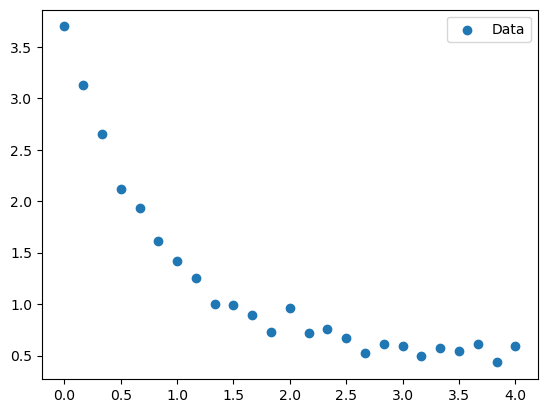

In [15]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Define the exponential decay model
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

x_data = np.linspace(0, 4, 25)
y_data = np.array([3.69825186, 3.13012273, 2.64854927, 2.12150665, 1.93384329,
       1.61788173, 1.42167637, 1.25036513, 0.9963676 , 0.98906286,
       0.89092495, 0.73276012, 0.96662416, 0.7227811 , 0.75511437,
       0.66954628, 0.52919564, 0.60806532, 0.5970682 , 0.49954995,
       0.57694673, 0.54343057, 0.60835945, 0.43258547, 0.59508027])

# Plot the data
plt.scatter(x_data, y_data, label='Data')
plt.legend()
plt.show()

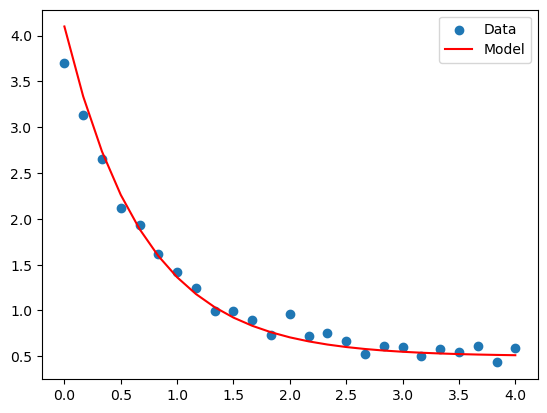

In [16]:
# Update these with your best guesses for a, b, c
p0 = [3.6, 1/0.7, 0.5]

# Plot the data and model
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, exponential_decay(x_data, *p0), color='red', label='Model')
plt.legend()
plt.show()

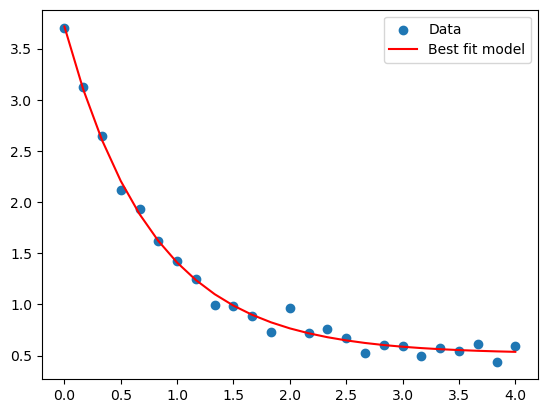

Optimized parameters: [3.19974894 1.2772422  0.51717429]


In [17]:
# Fit the model to the data
fitparams, fitcov = optimize.curve_fit(exponential_decay, x_data, y_data, p0=p0)

# Plot the data and the fit
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, exponential_decay(x_data, *fitparams), color='red', label='Best fit model')
plt.legend()
plt.show()

# Display optimized parameters
print("Optimized parameters:", fitparams)

## *Submitting this reading assignment*
Before submitting your work, please ensure you have worked carefully through all the cells. Afterward choose: File >> Save_and_Export_Notebook_As >> HTML. This will download an HTML version of your notebook to your computer which you can upload to Canvas